# **Credit Card Default Prediction**

This project focuses on understanding the factors that contribute to credit card payment defaults and building a predictive model to identify customers who are at risk. By exploring the dataset, preparing the features, and testing different machine learning algorithms, the project aims to create a practical baseline solution for default prediction.

The goal is not only to build an accurate model, but also to walk through the full workflow: data exploration, preprocessing, model training, evaluation, and interpretation of results. This helps develop a clear understanding of how real-world credit risk prediction problems are approached in machine learning.



In [58]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
# import dataset
df = pd.read_csv("UCI_Credit_Card.csv")
print("Shape:", df.shape)
print("Columns:", df.columns)

Shape: (30000, 25)
Columns: Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')


## **Data Cleaning and preprocessing**
In this section we will check for any missing values in the dataset and prepare our data for EDA and Feature engineering

In [4]:
# Missing values 
df.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [5]:
print(df.dtypes)

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object


In [6]:
# Sanity checks

print(df["ID"].is_monotonic_increasing)         # should return True

# check for any unexpected values
cols = ["MARRIAGE", "EDUCATION", "SEX", "default.payment.next.month"]
for col in cols:
    print(f"{col} unique values - {df[col].nunique()} - {df[col].unique()}")

# duplicacy check
print(f"Number of duplicates: {df["ID"].duplicated().sum()}")

print(df.describe().T)        # Look for value ranges/errors

True
MARRIAGE unique values - 4 - [1 2 3 0]
EDUCATION unique values - 7 - [2 1 3 5 4 6 0]
SEX unique values - 2 - [2 1]
default.payment.next.month unique values - 2 - [1 0]
Number of duplicates: 0
                              count           mean            std       min  \
ID                          30000.0   15000.500000    8660.398374       1.0   
LIMIT_BAL                   30000.0  167484.322667  129747.661567   10000.0   
SEX                         30000.0       1.603733       0.489129       1.0   
EDUCATION                   30000.0       1.853133       0.790349       0.0   
MARRIAGE                    30000.0       1.551867       0.521970       0.0   
AGE                         30000.0      35.485500       9.217904      21.0   
PAY_0                       30000.0      -0.016700       1.123802      -2.0   
PAY_2                       30000.0      -0.133767       1.197186      -2.0   
PAY_3                       30000.0      -0.166200       1.196868      -2.0   
PAY_4        

From the dataset description, we come across a few nuisances in the data:

- **Education**: 
  - (1 = graduate school, 2 = university, 3 = high school, 4 = others, 5 = unknown, 6 = unknown)  
  - We will map 0, 5, 6 → 0 (0 represents unknown)

- **Marriage**: 
  - (1 = married, 2 = single, 3 = others)  
  - 0 can be referred to as unknown

- **PAY_x columns**: 
  - (-2, -1 = pay duly/early; 1 = payment delay for 1 month, 2 = payment delay for 2 months, …, 8 = payment delay for 8 months, 9 = payment delay for 9 months or more)  
  - We will map -2 and -1 → 0 (no payment delay)


In [7]:
# mapping
df["EDUCATION"] = df["EDUCATION"].replace({0:0, 5:0, 6:0})

df["MARRIAGE"] = df["MARRIAGE"].replace({0:0})

cols = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
for col in cols:
    df[col] = df[col].replace({-1:0, -2:0})

In [8]:
df = df.rename(columns={"default.payment.next.month": "DEFAULT"})

Now the data is ready for Exploratory Data Analysis. (EDA)

## **Exploratory Data Analysis**

We will look into the distribution and relationships between features and the target variables. Learnings from Our EDA can be directly applied to make features during feature engineering.

In [9]:
# we will check for class imbalance
df["DEFAULT"].value_counts(normalize=True)

DEFAULT
0    0.7788
1    0.2212
Name: proportion, dtype: float64

As expected, our default and non-default classes are highly imbalanced, which can lead to misleading results for our classifier.  
This issue will be handled carefully during modeling using **SMOTE** or **class weights**.

#### Default Rate Among Different Groups

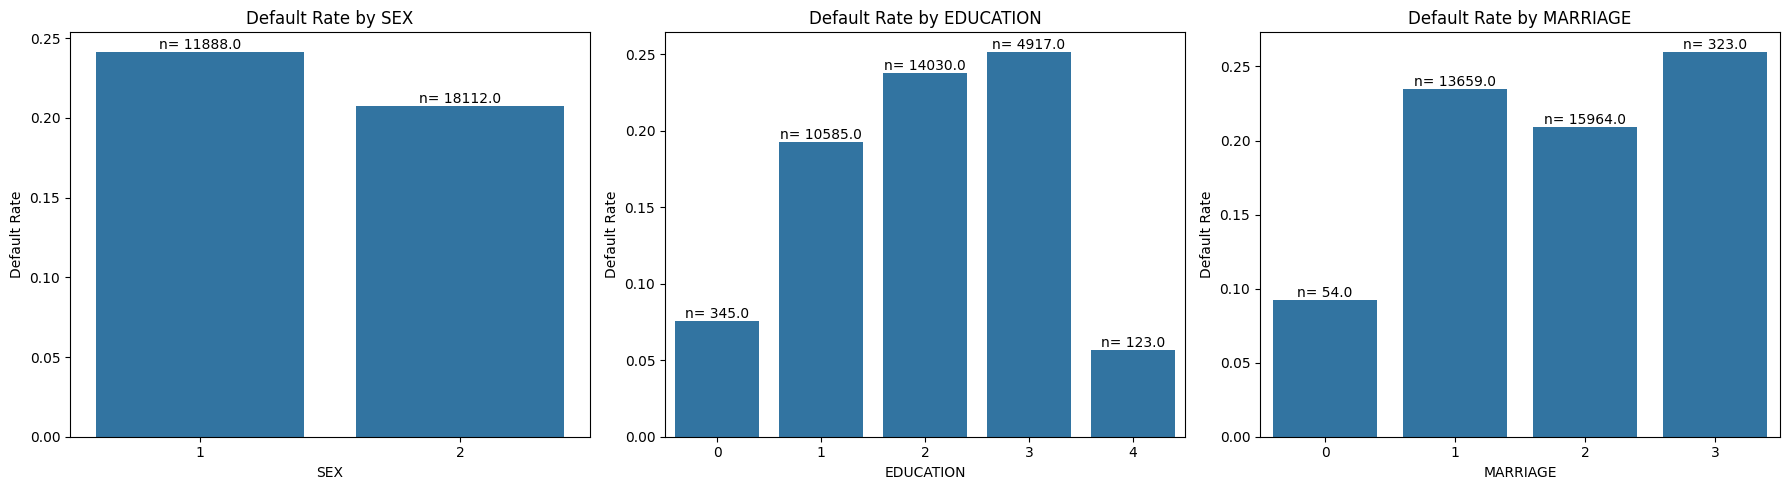

In [10]:
categorical_features = ["SEX", "EDUCATION", "MARRIAGE"]

plt.figure(figsize=(18,5))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, len(categorical_features), i)
    
    # create default rate, count for each group
    grouped = df.groupby(feature)["DEFAULT"].agg(["mean", "count"]).reset_index()
    grouped.rename(columns={"mean": "default_rate"}, inplace=True)

    # plot on barplot
    ax = sns.barplot(data=grouped, x=feature, y="default_rate")

    # add counts above bars
    for idx, row in grouped.iterrows():
        ax.text(idx, row["default_rate"], f"n= {row["count"]}", ha="center", va="bottom", fontsize=10, color="black")

    plt.title(f'Default Rate by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Default Rate') 

plt.tight_layout()
plt.show()

**Default Rate by Categorical Features**

We examined default rates across several demographic variables (SEX, EDUCATION, MARRIAGE) and included sample counts for each category to avoid misinterpreting small groups.
- **SEX**: Balanced sample sizes → default rates are reliable.
- **EDUCATION**: Categories 1, 2, and 3 have large sample sizes and show meaningful differences. Categories 0 and 4 are very small, so their rates should not be overinterpreted.
- **MARRIAGE**: Categories 1 and 2 are reliable; category 3 is small, and category 0 is too small to provide stable insights.

Including sample counts helped ensure that conclusions were based on statistically stable groups, avoiding misleading insights from tiny categories.

#### Default rate among different age groups

In [11]:
# assign 5 equal sized age bins
df["age_bins"] = pd.qcut(df["AGE"], 5, duplicates="drop")

# Agg on mean and count to see statiscal significance
default_by_age = df.groupby("age_bins", observed=False)["DEFAULT"].agg(["mean", "count"]).reset_index()
default_by_age.rename(columns={"mean": "default_rate"}, inplace=True)
default_by_age

,age_bins,default_rate,count
0,"(20.999, 27.0]",0.241975,6604
1,"(27.0, 31.0]",0.195876,5626
2,"(31.0, 37.0]",0.205113,6728
3,"(37.0, 43.0]",0.217563,5056
4,"(43.0, 79.0]",0.243234,5986


In [12]:
# compute confidenece intervals by "wilson method"
from statsmodels.stats.proportion import proportion_confint
ci_low = []
ci_high = []

for _, row in default_by_age.iterrows():
    p = row["default_rate"]
    n = row["count"]
    low, high = proportion_confint(count=p*n, nobs=n, method="wilson")
    ci_low.append(low)
    ci_high.append(high)

default_by_age["ci_low"] = ci_low
default_by_age["ci_high"] = ci_high
default_by_age 

,age_bins,default_rate,count,ci_low,ci_high
0,"(20.999, 27.0]",0.241975,6604,0.231797,0.252452
1,"(27.0, 31.0]",0.195876,5626,0.185715,0.206453
2,"(31.0, 37.0]",0.205113,6728,0.195634,0.214928
3,"(37.0, 43.0]",0.217563,5056,0.206407,0.229148
4,"(43.0, 79.0]",0.243234,5986,0.232533,0.254265


#### Correlation for default rate and payment habits

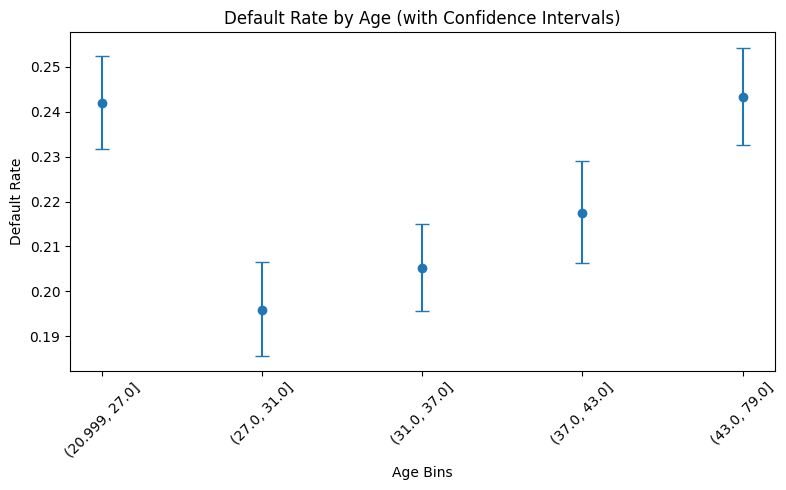

In [13]:
# Plot error bars for visualization
plt.figure(figsize=(8,5))
plt.errorbar(x = default_by_age["age_bins"].astype(str),
             y = default_by_age["default_rate"],
             yerr= [default_by_age["default_rate"] - default_by_age["ci_low"], default_by_age["ci_high"] - default_by_age["default_rate"]], 
             fmt="o", capsize=5
             )
plt.title("Default Rate by Age (with Confidence Intervals)")
plt.xlabel("Age Bins")
plt.ylabel("Default Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Default Rate by Age Group**

To analyze how age affects default likelihood, I binned customers into 5 age groups using quantile-based binning (ensuring each group had similar sample sizes). I then calculated the default rate for each bin. Calculated CI for category size imbalance

I found a U-shaped pattern:
- Youngest and oldest age groups show higher default rates
- Middle-aged customers (27–37) show the lowest default rate

This suggests that age has a non-linear relationship with credit risk.

In [14]:
cols = ['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df["average_payment"] = df[cols].apply(lambda row: row.mean(), axis=1)
corr, p_value = pearsonr(df['average_payment'], df['DEFAULT'])
print("Correlation:", corr)
print("p-value:", p_value)

Correlation: 0.37603366963461105
p-value: 0.0



- `average_payment` (mean of PAY_0–PAY_6) correlates positively with default (r ≈ 0.38, p ≈ 0).  
- Interpretation: Customers who generally pay later are more likely to default.  
- Conclusion: `average_payment` is a meaningful predictive feature.

#### Correlation in default and credit limit

In [15]:
corr, p_value = pearsonr(df["LIMIT_BAL"], df["DEFAULT"])
print("Correlation:", corr)
print("p-value:", p_value)

Correlation: -0.15351987639350817
p-value: 1.3022439532535352e-157


#### Distribution checks
We will plot some key distributions to analize any insane outliers and skew.

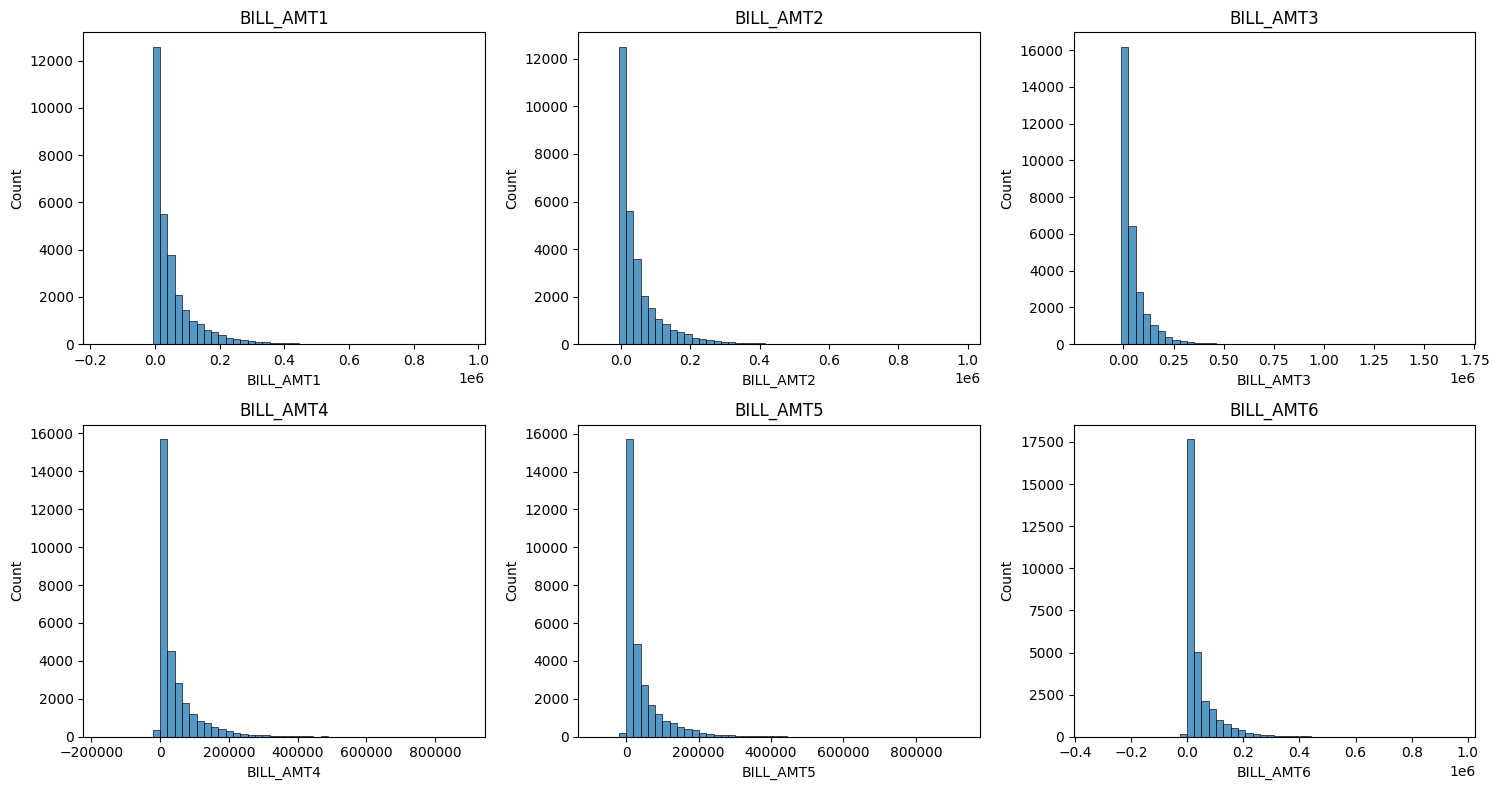

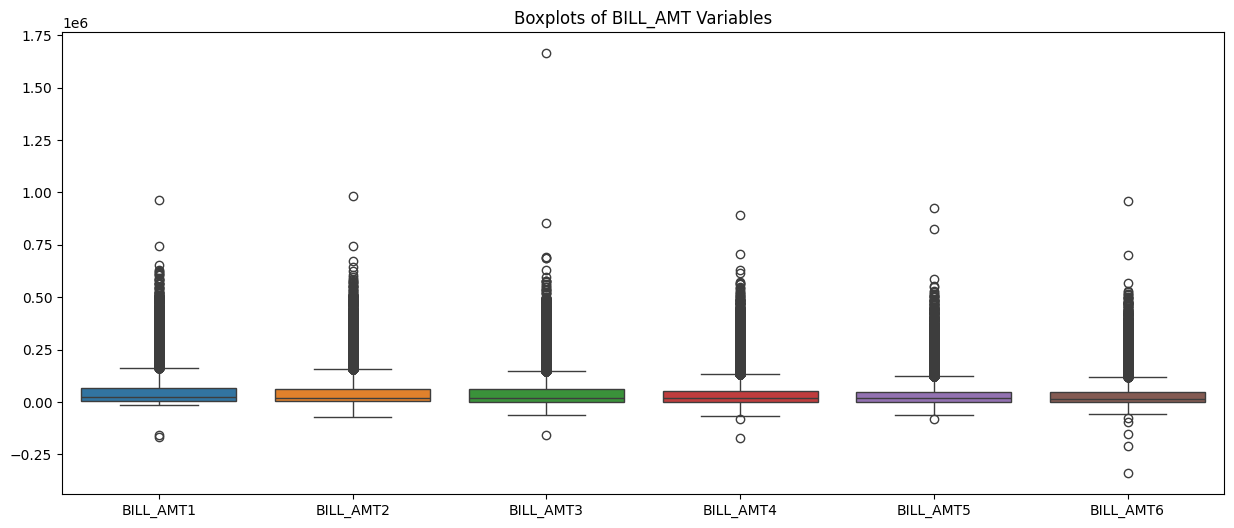

In [16]:
cols_bill = ["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]

plt.figure(figsize=(15,8))
for i, col in enumerate(cols_bill, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=50, kde=False)
    plt.title(col)

plt.tight_layout()
plt.show()

plt.figure(figsize=(15,6))
sns.boxplot(data=df[cols_bill])
plt.title("Boxplots of BILL_AMT Variables")
plt.show()


All six historical bill amounts are heavily right-skewed with long positive tails, which is expected in financial data. A small number of customers carry very large balances, while most carry lower balances.
Boxplots confirm the presence of many high outliers.

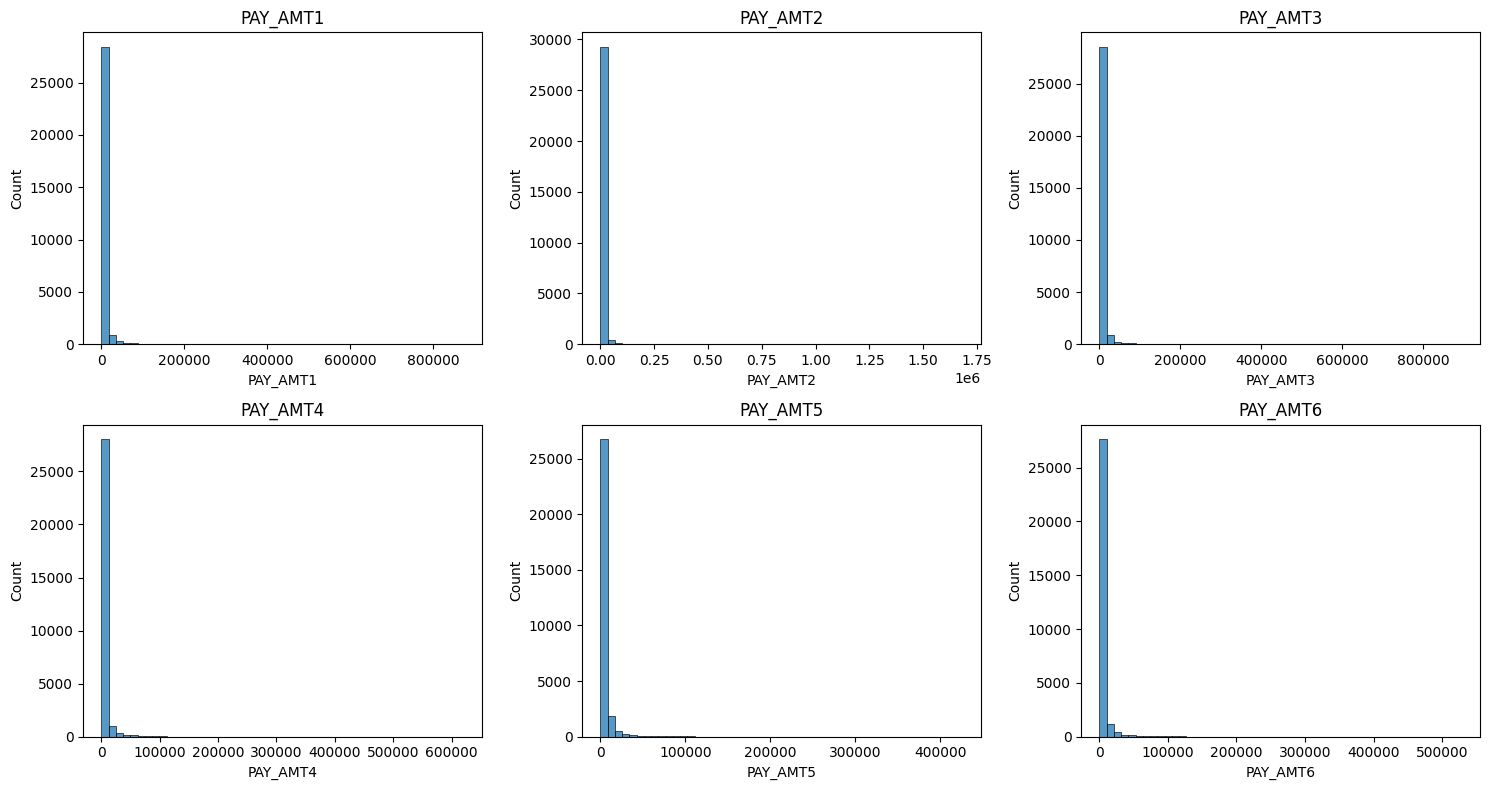

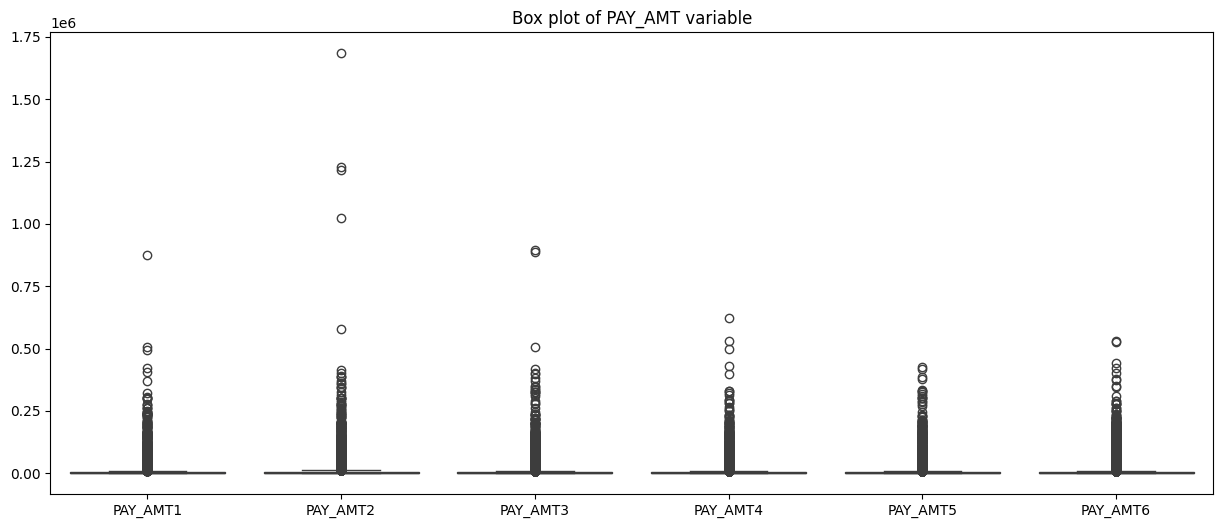

In [17]:
cols_pay = ['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

plt.figure(figsize=(15,8))
for i, col in enumerate(cols_pay, 1):
    plt.subplot(2,3,i)
    sns.histplot(df[col], bins=50, kde=False)
    plt.title(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,6))
sns.boxplot(data = df[cols_pay])
plt.title("Box plot of PAY_AMT variable")
plt.show()

The PAY_AMT variables are heavily zero-inflated and extremely right-skewed. Most customers make very small or zero payments, while a tiny number of customers make exceptionally large payments. Because of this, traditional histograms and boxplots are not very informative; the signal collapses near zero with only a few extreme outliers determining the visible range.

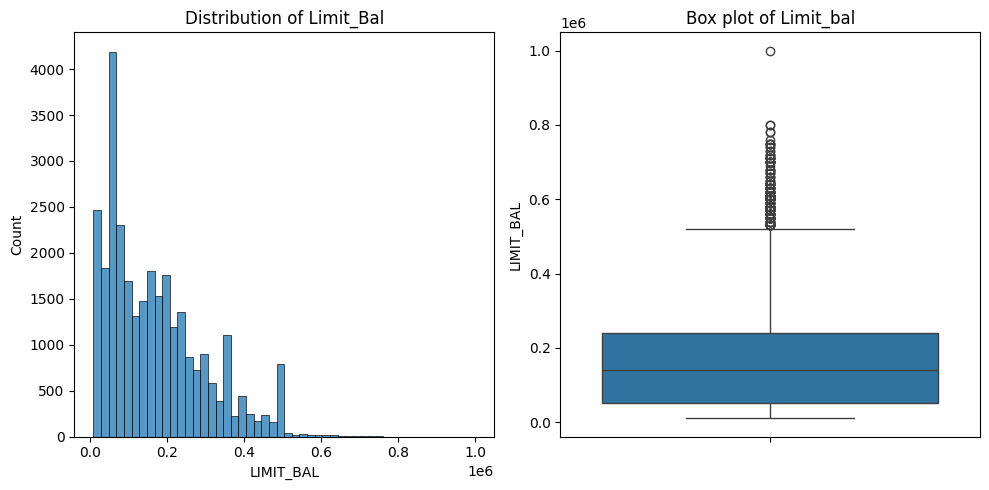

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(df["LIMIT_BAL"], bins=50, kde=False)
plt.title("Distribution of Limit_Bal")
plt.subplot(1,2,2)
sns.boxplot(data=df["LIMIT_BAL"])
plt.title("Box plot of Limit_bal")
plt.tight_layout()
plt.show()


The credit limit variable is heavily right-skewed, which is typical of financial datasets. Most customers have relatively low credit limits (between 10,000 and 200,000), while a smaller number have significantly higher limits. A very small set of customers have limits close to 1,000,000, which appear as outliers in the boxplot.

The outliers likely represent high-income customers and are not data errors. These values will be relevant during feature engineering: tree-based models can naturally handle the wide range, while linear models may require scaling or transformations to reduce the influence of extreme values.

#### Default Rate by Historical Repayment Status (PAY_0 to PAY_6)

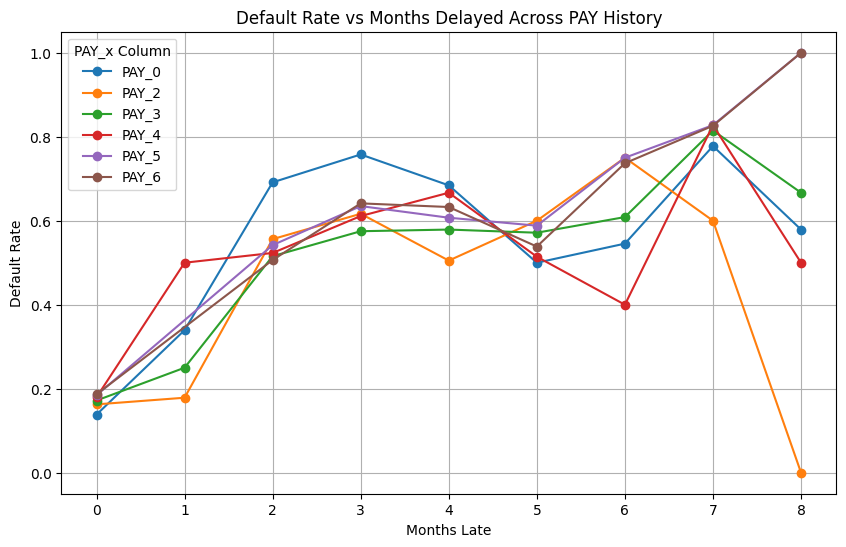

In [19]:
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
default_rates = {}

for col in pay_cols:
    grouped = df.groupby(col)["DEFAULT"].mean()
    default_rates[col] = grouped

plt.figure(figsize=(10,6))

for col in pay_cols:
    plt.plot(default_rates[col].index, default_rates[col].values, marker='o', label=col)

plt.title("Default Rate vs Months Delayed Across PAY History")
plt.xlabel("Months Late")
plt.ylabel("Default Rate")
plt.legend(title="PAY_x Column")
plt.grid(True)
plt.show()


In [20]:
pay_default_corr = df[pay_cols + ['DEFAULT']].corr()['DEFAULT'].drop('DEFAULT')
pay_default_corr.sort_values(ascending=False)

PAY_0    0.396019
PAY_2    0.327093
PAY_3    0.286999
PAY_4    0.269055
PAY_5    0.260850
PAY_6    0.244437
Name: DEFAULT, dtype: float64

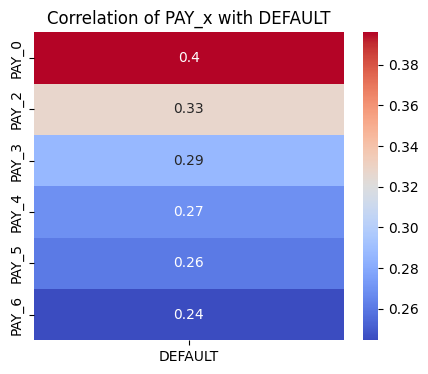

In [21]:
plt.figure(figsize=(5,4))
sns.heatmap(pay_default_corr.to_frame(), annot=True, cmap="coolwarm")
plt.title("Correlation of PAY_x with DEFAULT")
plt.show()

We analyzed default rates across six historical repayment indicators (PAY_0 to PAY_6), representing whether the customer was late in the past six billing cycles.

Default probability increases consistently with the number of months a payment is overdue. Customers who paid on time had the lowest default rates, while those who were 2 or more months late experienced a sharp rise in risk.

The effect of late payment is strongest for recent months. PAY_0 (most recent billing cycle) shows the highest correlation with default (0.396), while the influence gradually decreases for older delays (PAY_6: 0.244). This pattern supports a key credit-risk principle: **recency and severity of missed payments are critical predictors of future default.**

#### Correlation heatmap

Correlation with DEFAULT:

PAY_0              0.396019
average_payment    0.376034
PAY_2              0.327093
PAY_3              0.286999
PAY_4              0.269055
PAY_5              0.260850
PAY_6              0.244437
EDUCATION          0.056405
AGE                0.013890
BILL_AMT6         -0.005372
BILL_AMT5         -0.006760
BILL_AMT4         -0.010156
ID                -0.013952
BILL_AMT3         -0.014076
BILL_AMT2         -0.014193
BILL_AMT1         -0.019644
MARRIAGE          -0.024339
SEX               -0.039961
PAY_AMT6          -0.053183
PAY_AMT5          -0.055124
PAY_AMT3          -0.056250
PAY_AMT4          -0.056827
PAY_AMT2          -0.058579
PAY_AMT1          -0.072929
LIMIT_BAL         -0.153520
Name: DEFAULT, dtype: float64


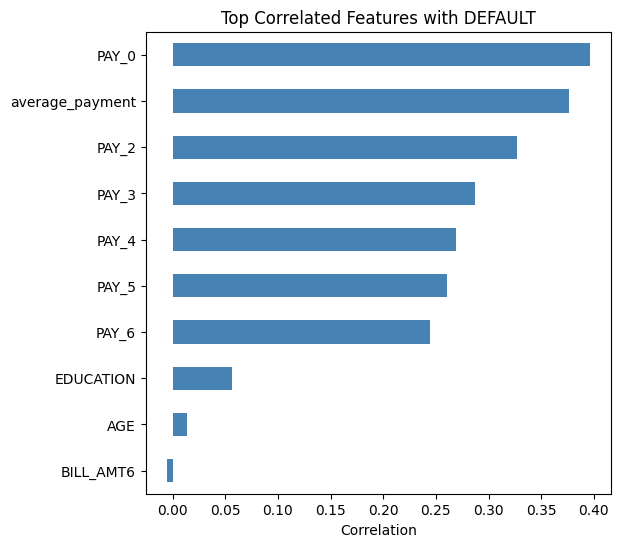

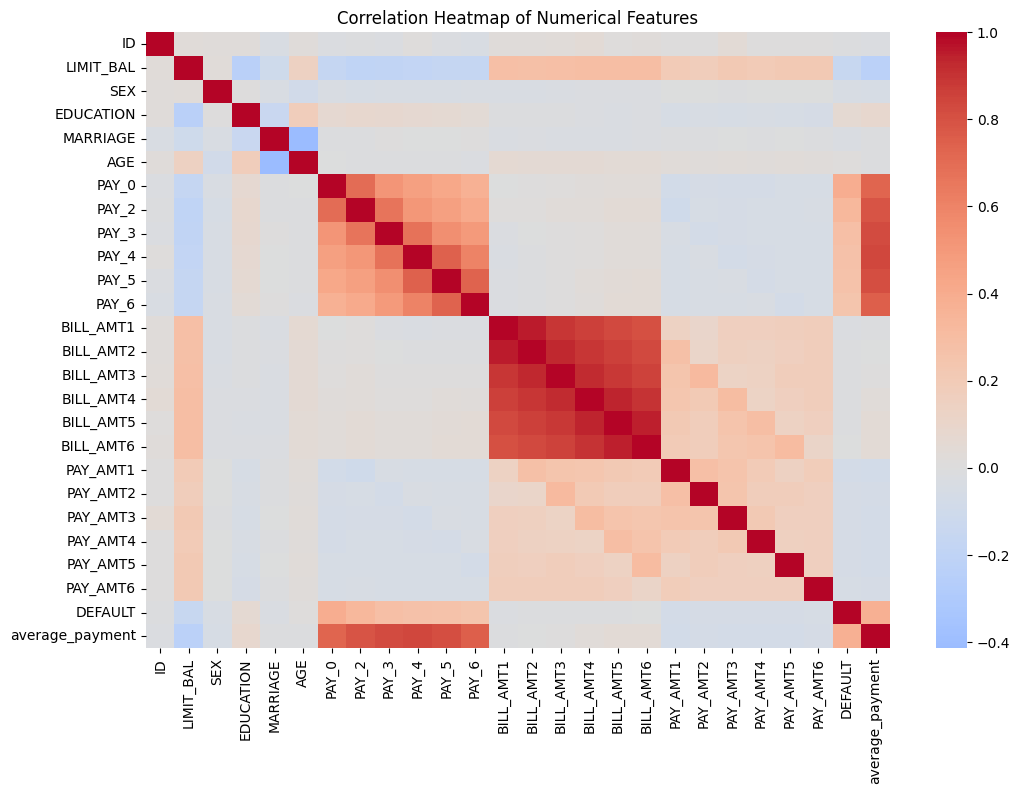

In [22]:
# Select numeric features only
numeric_df = df.select_dtypes(include="number")

# Correlation of all numeric features with DEFAULT
corr_with_default = numeric_df.corr()["DEFAULT"].drop("DEFAULT").sort_values(ascending=False)
print("Correlation with DEFAULT:\n")
print(corr_with_default)

# Plot Top 10 positive/negative correlations with DEFAULT (optional but clean)
plt.figure(figsize=(6,6))
corr_with_default.head(10).sort_values().plot(kind="barh", color="steelblue")
plt.title("Top Correlated Features with DEFAULT")
plt.xlabel("Correlation")
plt.show()

# Full correlation heatmap (numeric features)
plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", center=0, square=False)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

Correlation analysis reveals three distinct clusters in the dataset:

**- Repayment history features (PAY_0–PAY_6)** are strongly correlated with each other and with default, confirming repayment recency and severity as the most influential drivers.

**- Bill amount features (BILL_AMT1–6)** display high internal correlation but weak correlation with default, suggesting they measure consistent spending behavior rather than risk directly.

**- Payment amounts (PAY_AMT1–6)** show moderate correlation with bill amounts but limited predictive power individually.

LIMIT_BAL is negatively correlated with default, indicating that customers with higher assigned credit limits tend to be lower risk. Demographic features exhibit minimal linear correlation, suggesting limited predictive strength in isolation.

The diagonal blocks show feature-to-feature relationships (redundancy and behavioral grouping), while the vertical column aligned with DEFAULT reveals which features have predictive influence over default outcomes.

This correlation structure will guide feature engineering, particularly around reducing redundant bill/payment fields and focusing on behavioral repayment signals.

**Based on these insights, we now proceed to engineer features that better capture repayment behavior, financial capacity, and risk patterns while reducing redundancy from highly correlated variables.**

## **Feature Engineering**

Based on insights from the EDA, several patterns were observed in the repayment history (`PAY_0`–`PAY_6`) that motivated the creation of engineered behavioral features. The repayment status variables are ordinal indicators of how many months the customer was late, with more recent delays having a stronger relationship with default. Instead of relying only on the raw PAY columns independently, we derive summary features to capture delinquency in terms of **recency**, **severity**, and **frequency** — three dimensions that credit risk models commonly focus on.

The goal of feature engineering here is not to increase the number of variables, but to represent customer repayment behavior more effectively while reducing redundancy and noise within correlated monthly attributes.


In [23]:
# Recency-weighted score: recent delays carry more risk
df["late_score"] = (
    df["PAY_0"]*6 + df["PAY_2"]*5 + df["PAY_3"]*4 + 
    df["PAY_4"]*3 + df["PAY_5"]*2 + df["PAY_6"]
)

# Maximum delay (severity of worst lateness)
df["max_delay"] = df[pay_cols].max(axis=1)

# Number of months customer was late (frequency)
df["num_late_months"] = (df[pay_cols] > 0).sum(axis=1)

# Ever late (single late month indicates higher risk than none)
df["ever_late"] = (df["num_late_months"] > 0).astype(int)

# Usually late (more than half of the months show delays)
df["usually_late"] = (df["num_late_months"] > (len(pay_cols)/2)).astype(int)

# Severely late (3+ months late is considered high-risk behavior)
df["severely_late"] = (df["max_delay"] >= 3).astype(int)

These engineered variables condense the six monthly PAY indicators into interpretable behavioral signals that better reflect real-world credit risk patterns. They allow the model to distinguish between occasional late payers, consistently late customers, and those with severe recent delinquencies.

In [24]:
# High risk (if used 90% of the credit limit)
df["maxed_credit_use"] = (df["BILL_AMT6"]/df["LIMIT_BAL"] >= 0.9).astype(int)

# flags usually minimum payments
min_pay_cols = []
for i in range(1,7):
    col = f"min_pay{i}"
    df[col] = ((df[f"PAY_AMT{i}"] / df[f"BILL_AMT{i}"].replace(0, np.nan)) <= 0.05).astype(int)
    min_pay_cols.append(col)
# Summary behavioral feature
df["usually_min_payment"] = (df[min_pay_cols].sum(axis=1) > 3).astype(int)


# flags usually high payments
high_pay_cols = []
for i in range(1,7):
    col = f"high_pay_{i}"
    df[col] = ((df[f"PAY_AMT{i}"] / df[f"BILL_AMT{i}"].replace(0, np.nan)) >= 0.75).astype(int)
    high_pay_cols.append(col)

# summarize behavioral feature
df["usually_high_payment"] = (df[high_pay_cols].sum(axis=1) > 3).astype(int)

# Average percent of bill paid over 6 months
df["avg_payment_ratio"] = (
    (df[[f"PAY_AMT{i}" for i in range(1,7)]] /
     df[[f"BILL_AMT{i}" for i in range(1,7)]].replace(0, np.nan)
    ).mean(axis=1)
)

# no bill ever customers
df["no_bill_history"] = (df[cols_bill].sum(axis=1) == 0).astype(int)

# Drop the temporary individual binary flags
df.drop(columns=high_pay_cols, inplace=True)
df.drop(columns=min_pay_cols, inplace=True)

In [25]:
# Bill trend
df["bill_trend"] = df[cols_bill].apply(lambda row: np.polyfit(range(6), row.values, 1)[0], axis=1)

# Pay trend
df["pay_trend"] = df[cols_pay].apply(lambda row: np.polyfit(range(6), row.values, 1)[0], axis=1)

df["bill_change"] = df["BILL_AMT6"] - df["BILL_AMT1"]
df["payment_ratio_change"] = (df["PAY_AMT6"] / df["BILL_AMT6"].replace(0, np.nan)) - (df["PAY_AMT1"] / df["BILL_AMT1"].replace(0, np.nan))

df["bill_to_pay_trend"] = df["bill_trend"] / df["pay_trend"].replace(0, np.nan)
df["bill_to_pay_trend"] = df["bill_to_pay_trend"].fillna(0)


In [26]:
# Target
target = "DEFAULT"

# Feature groups
demographics = ["SEX", "EDUCATION", "MARRIAGE", "age_bins"]  
limit_feature = ["LIMIT_BAL"]

# Raw features
raw_pay_status = ["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]
raw_bill_amounts = ["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]
raw_pay_amounts = ["PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"] 

engineered_behavior = ["late_score", "max_delay", "num_late_months", "ever_late", "usually_late", "severely_late"]

engineered_repayment_patterns = ["usually_min_payment", "usually_high_payment", "avg_payment_ratio"]

engineered_trends = ["bill_trend", "pay_trend", "bill_change", "payment_ratio_change", "bill_to_pay_trend", "no_bill_history"]

# strongest predictor
strongest_predictor = ["PAY_0"]


In [27]:
# seperating features as per models
linear_features = (
    demographics + limit_feature +
    engineered_behavior +
    engineered_repayment_patterns +
    engineered_trends +
    strongest_predictor
)

tree_features = (
    demographics + limit_feature +
    raw_pay_status + raw_bill_amounts + raw_pay_amounts +
    engineered_behavior + engineered_repayment_patterns + engineered_trends
)


PAY_0 is included as a standalone feature only for linear models, since it is the strongest individual predictor and represents immediate delinquency risk. In tree-based models, PAY_0 already exists within the raw PAY variables, so it does not need to be duplicated.

In [28]:
# quick sanity check before closing FE. 
df.isna().sum()

ID                          0
LIMIT_BAL                   0
SEX                         0
EDUCATION                   0
MARRIAGE                    0
AGE                         0
PAY_0                       0
PAY_2                       0
PAY_3                       0
PAY_4                       0
PAY_5                       0
PAY_6                       0
BILL_AMT1                   0
BILL_AMT2                   0
BILL_AMT3                   0
BILL_AMT4                   0
BILL_AMT5                   0
BILL_AMT6                   0
PAY_AMT1                    0
PAY_AMT2                    0
PAY_AMT3                    0
PAY_AMT4                    0
PAY_AMT5                    0
PAY_AMT6                    0
DEFAULT                     0
age_bins                    0
average_payment             0
late_score                  0
max_delay                   0
num_late_months             0
ever_late                   0
usually_late                0
severely_late               0
maxed_cred

In [29]:
# If there was no outstanding bill (bill amount = 0), the payment ratio is undefined.
# Filling with 1 represents a full-payment equivalent, since no repayment was required.
df["avg_payment_ratio"] = df["avg_payment_ratio"].fillna(1)

# When either the first or last recorded bill is zero, the change ratio becomes undefined.
# Filling with 0 assumes no directional change in repayment behavior.
df["payment_ratio_change"] = df["payment_ratio_change"].fillna(0)

print("Dataframe Shape:", df.shape)
print("Dataframe Columns:", df.columns)


Dataframe Shape: (30000, 43)
Dataframe Columns: Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT',
       'age_bins', 'average_payment', 'late_score', 'max_delay',
       'num_late_months', 'ever_late', 'usually_late', 'severely_late',
       'maxed_credit_use', 'usually_min_payment', 'usually_high_payment',
       'avg_payment_ratio', 'no_bill_history', 'bill_trend', 'pay_trend',
       'bill_change', 'payment_ratio_change', 'bill_to_pay_trend'],
      dtype='object')


Feature engineering in this project focused on translating raw monthly repayment and billing records into meaningful behavioral signals. Instead of relying solely on the original PAY, BILL, and PAY_AMT columns, which are often noisy and highly correlated, we engineered features that capture five key dimensions of credit risk:

- **Recency** – Recent late payments impact default probability more heavily (e.g., `late_score`).
- **Severity** – The worst observed delinquency level (`max_delay`, `severely_late`).
- **Frequency** – Whether late behavior is occasional or habitual (`num_late_months`, `usually_late`).
- **Repayment quality** – Proportion of the bill being repaid and payment patterns (`avg_payment_ratio`, `usually_min_payment`, `usually_high_payment`).
- **Trend and direction** – Whether debt is growing and whether payments are improving (`bill_trend`, `pay_trend`, `bill_change`, `payment_ratio_change`, `bill_to_pay_trend`).

These features provide a condensed and interpretable representation of customer behavior that is more suitable for modeling than the raw time-based columns alone. For model-building purposes, we will maintain two feature subsets:  
- A **reduced, engineered feature set** for linear models, where raw correlated variables may violate assumptions.  
- A **combined raw + engineered set** for decision trees and boosting models, which can leverage non-linear interactions in the data.


## **Modelling**

## Logistic Regression

In [30]:
X = df[linear_features]
y = df[target]

# splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

In [31]:
numeric_features = list(set(linear_features) - set(demographics))

preprocessor = ColumnTransformer([
    ("encoder", OneHotEncoder(sparse_output=True), demographics),
    ("scale", StandardScaler(), numeric_features)
])

pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(class_weight="balanced", solver="liblinear"))
])

params_grid = {
    "model__penalty": ["l1", "l2"],
    "model__C": [0.01, 0.1, 0.5, 1, 10]
}

grid_search = GridSearchCV(pipeline, param_grid=params_grid, cv=3)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best tuned model:", best_model)

Best tuned model: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('encoder', OneHotEncoder(),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE', 'age_bins']),
                                                 ('scale', StandardScaler(),
                                                  ['usually_min_payment',
                                                   'pay_trend',
                                                   'no_bill_history',
                                                   'ever_late', 'PAY_0',
                                                   'num_late_months',
                                                   'max_delay',
                                                   'usually_high_payment',
                                                   'bill_trend',
                                                   'payment_ratio_change',
                  

In [32]:
# Extract feature names from ColumnTransformer inside Pipeline
ohe = best_model.named_steps["preprocess"].named_transformers_["encoder"]
encoded_cat_cols = ohe.get_feature_names_out(demographics)

feature_names = list(encoded_cat_cols) + numeric_features

# extract the coeff
coeffs = best_model.named_steps["model"].coef_[0]

# create a df
coef_df = (
    pd.DataFrame({"Features": feature_names, "Coefficient": coeffs})
    .sort_values(by="Coefficient", ascending=False)
    .reset_index(drop=True)
)

print(coef_df.head(10))      # Top 10 positive (higher risk)
print(coef_df.tail(10))      # Top 10 negative (lower risk)

               Features  Coefficient
0             max_delay     0.595224
1       num_late_months     0.573016
2                 PAY_0     0.549969
3           EDUCATION_2     0.315327
4           EDUCATION_1     0.302232
5            MARRIAGE_3     0.262472
6           EDUCATION_3     0.213492
7       no_bill_history     0.175560
8            MARRIAGE_1     0.160062
9  payment_ratio_change     0.062165
                 Features  Coefficient
23                  SEX_1    -0.098129
24          severely_late    -0.115717
25  age_bins_(27.0, 31.0]    -0.164436
26                  SEX_2    -0.238863
27              ever_late    -0.250035
28              LIMIT_BAL    -0.265007
29             late_score    -0.383450
30            EDUCATION_4    -0.464946
31            EDUCATION_0    -0.703096
32             MARRIAGE_0    -0.772652


In [33]:
coef_df.style.background_gradient(cmap='coolwarm', subset=["Coefficient"])

,Features,Coefficient
0,max_delay,0.595224
1,num_late_months,0.573016
2,PAY_0,0.549969
3,EDUCATION_2,0.315327
4,EDUCATION_1,0.302232
5,MARRIAGE_3,0.262472
6,EDUCATION_3,0.213492
7,no_bill_history,0.175560
8,MARRIAGE_1,0.160062
9,payment_ratio_change,0.062165


### Re-evaluating Engineered Features Based on Model Coefficients

From the initial logistic regression results, we observed that `max_delay` and `num_late_months` were the strongest predictors of default, while the composite feature `late_score` appeared with a negative coefficient. This inversion suggests that the information captured by `late_score` is already explained by other lateness-related features, creating multicollinearity and reducing model interpretability.

Therefore, `late_score` would removed from the linear model feature set while retained for tree-based models, which are not sensitive to multicollinearity.


In [34]:
linear_features_final = [f for f in linear_features if f != "late_score"]
X = df[linear_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

numeric_features = list(set(linear_features_final) - set(demographics))

preprocessor = ColumnTransformer([
    ("encoder", OneHotEncoder(sparse_output=False), demographics),
    ("scale", StandardScaler(), numeric_features)
])
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(class_weight="balanced", solver="liblinear"))
])

grid_search = GridSearchCV(pipeline, param_grid=params_grid, cv=3, scoring="roc_auc")
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

In [35]:
# Extract feature names from ColumnTransformer inside Pipeline
ohe = best_model.named_steps["preprocess"].named_transformers_["encoder"]
encoded_cat_cols = ohe.get_feature_names_out(demographics)

feature_names = list(encoded_cat_cols) + numeric_features

# extract the coeff
coeffs = best_model.named_steps["model"].coef_[0]

# create a df
coef_df = (
    pd.DataFrame({"Features": feature_names, "Coefficient": coeffs})
    .sort_values(by="Coefficient", ascending=False)
    .reset_index(drop=True)
)

coef_df.style.background_gradient(cmap="coolwarm", subset=["Coefficient"])

,Features,Coefficient
0,PAY_0,0.453161
1,max_delay,0.440816
2,num_late_months,0.320405
3,EDUCATION_2,0.315963
4,EDUCATION_1,0.301736
5,MARRIAGE_3,0.262906
6,EDUCATION_3,0.212237
7,no_bill_history,0.172539
8,MARRIAGE_1,0.165054
9,payment_ratio_change,0.060001


After removing `late_score`, the coefficient directions of all late-payment features stabilized and aligned with expected credit risk behavior. This confirmed that the original composite feature introduced redundancy in the presence of more granular severity and frequency variables.


In [36]:
# Evaluate model using cross_val_score
auc = cross_val_score(best_model, X_train, y_train, cv=5, scoring="roc_auc").mean()
f1 = cross_val_score(best_model, X_train, y_train, cv=5, scoring="f1").mean()

print("Baseline Logistic Regression - ROC AUC:", auc)
print("Baseline Logistic Regression - F1 Score:", f1)

Baseline Logistic Regression - ROC AUC: 0.7696602346221738
Baseline Logistic Regression - F1 Score: 0.5297073516235703


The baseline logistic regression model achieved an ROC-AUC of 0.77 and an F1-score of 0.53. This indicates that the model can distinguish between defaulters and non-defaulters with reasonable reliability. However, the linear decision boundary of logistic regression limits its ability to capture non-linear behavioral patterns present in credit usage and repayment trends

              precision    recall  f1-score   support

           0       0.88      0.79      0.83     18691
           1       0.46      0.62      0.53      5309

    accuracy                           0.76     24000
   macro avg       0.67      0.71      0.68     24000
weighted avg       0.79      0.76      0.77     24000



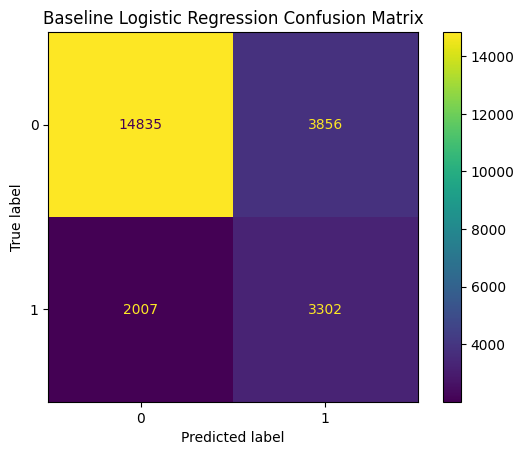

In [37]:

y_pred = cross_val_predict(best_model, X_train, y_train, cv=5)

print(classification_report(y_train, y_pred))
cm = confusion_matrix(y_train, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="viridis")
plt.title("Baseline Logistic Regression Confusion Matrix")
plt.show()

The baseline logistic regression achieves a recall of 0.62 for defaulters, meaning the model successfully identifies 62% of customers who default. The confusion matrix shows that false negatives (missed defaulters) remain a major source of error, which is expected at this stage since no threshold optimization has been applied. Overall, the ROC-AUC of ~0.77 indicates good ranking ability, but more expressive models (e.g., Random Forest, XGBoost) may improve recall without excessively increasing false positives.


## Random Forest Classifier

In [38]:
X = df[tree_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# setting up pipelines
preprocessor = ColumnTransformer([
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False), demographics)
], remainder="passthrough")

pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("rnf", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

params_dist = {
    "rnf__n_estimators": np.linspace(300, 1200, 7, dtype=int),
    "rnf__max_depth": [None, 20, 30, 40, 60, 80],
    "rnf__min_samples_split": [2, 5, 10, 15, 20],
    "rnf__min_samples_leaf": [1, 2, 4, 8],
    "rnf__max_features": ["sqrt", "log2"], 
    "rnf__bootstrap": [True]
}

# Random search for best parameters
random_search = RandomizedSearchCV(pipeline, param_distributions=params_dist, n_iter=25, scoring="roc_auc", cv=3, n_jobs=-1, random_state=42, verbose=1)
random_search.fit(X_train, y_train)

print("Best from random search:", random_search.best_params_)
best = random_search.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best from random search: {'rnf__n_estimators': 600, 'rnf__min_samples_split': 15, 'rnf__min_samples_leaf': 8, 'rnf__max_features': 'log2', 'rnf__max_depth': 80, 'rnf__bootstrap': True}


In [40]:
# Now we will do a grid search around these values to get the best hyperparameters

refined_grid = {
    "rnf__n_estimators": [best["rnf__n_estimators"] - 100,
                          best["rnf__n_estimators"],
                          best["rnf__n_estimators"] + 100],

    "rnf__max_depth": [best["rnf__max_depth"] - 10,
                       best["rnf__max_depth"],
                       best["rnf__max_depth"] + 10] if best["rnf__max_depth"] else [None],
    
    "rnf__min_samples_split": [best["rnf__min_samples_split"] - 2,
                               best["rnf__min_samples_split"],
                               best["rnf__min_samples_split"] + 2],
    
    "rnf__min_samples_leaf": [best["rnf__min_samples_leaf"] - 1,
                              best["rnf__min_samples_leaf"],
                              best["rnf__min_samples_leaf"] + 1],
    
    "rnf__max_features": [best["rnf__max_features"]],
    "rnf__bootstrap": [True]
}

for k in refined_grid:
    refined_grid[k] = list(
        set(
            [v for v in refined_grid[k] if isinstance(v, int) and v > 0] +
            [v for v in refined_grid[k] if not isinstance(v, int)]
        )
    )

In [41]:
grid_search = GridSearchCV( random_search.best_estimator_, param_grid=refined_grid, scoring="roc_auc", cv=3, n_jobs=-1, verbose=1 )

grid_search.fit(X_train, y_train)
best_model_rnf = grid_search.best_estimator_
print("Best model refined:", best_model_rnf)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best model refined: Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE', 'age_bins'])])),
                ('rnf',
                 RandomForestClassifier(class_weight='balanced', max_depth=80,
                                        max_features='log2', min_samples_leaf=9,
                                        min_samples_split=17, n_estimators=700,
                                        random_state=42))])


In [42]:
# Evaluate model performance 
auc = cross_val_score(best_model_rnf, X_train, y_train, cv=5, scoring="roc_auc").mean()
f1 = cross_val_score(best_model_rnf, X_train, y_train, cv=5, scoring="f1").mean()

print("Random Forest - ROC AUC:", auc)
print("Random Forest - F1 Score:", f1)

Random Forest - ROC AUC: 0.7832184841642379
Random Forest - F1 Score: 0.5434753578286247


              precision    recall  f1-score   support

           0       0.87      0.85      0.86     18691
           1       0.52      0.57      0.54      5309

    accuracy                           0.79     24000
   macro avg       0.70      0.71      0.70     24000
weighted avg       0.80      0.79      0.79     24000



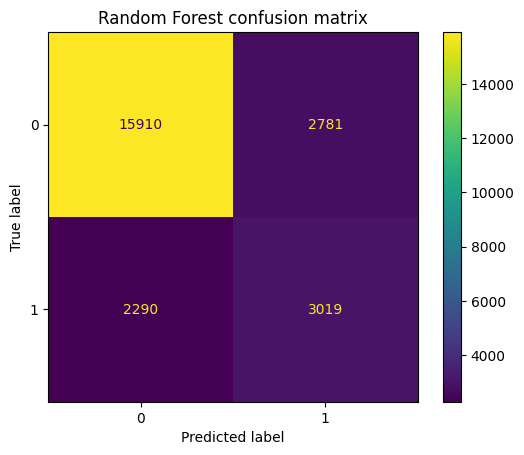

In [43]:
# Confusion matrix
y_pred = cross_val_predict(best_model_rnf, X_train, y_train, cv=5)
print(classification_report(y_train, y_pred))
cm_rnf = confusion_matrix(y_train, y_pred)
ConfusionMatrixDisplay(cm_rnf).plot(cmap="viridis")
plt.title("Random Forest confusion matrix")
plt.show()

While Random Forest yielded a small improvement in ROC-AUC (+0.014) and F1 score (+0.013), the gain must be considered alongside increased model complexity and reduced interpretability. In regulated credit environments, transparency and explainability are often prioritized. 
Therefore, such marginal performance gains may not justify replacing a simpler and more interpretable logistic regression model unless it translates into measurable reductions in default-related losses.

In [44]:
# Random forest Feature importance 
ohe = best_model_rnf.named_steps["preprocess"].named_transformers_["encoder"]
encoded_features = ohe.get_feature_names_out(demographics)
other_features = [f for f in X.columns if f not in demographics]
feature_names_rnf = list(encoded_features) + other_features


# Create importance dataframe
importances = pd.DataFrame({
    "feature": feature_names_rnf,
    "importance": best_model_rnf.named_steps["rnf"].feature_importances_
}).sort_values(by="importance", ascending=False)

print(importances.head(15))


              feature  importance
35         late_score    0.079025
17              PAY_0    0.062431
37    num_late_months    0.057778
36          max_delay    0.049905
38          ever_late    0.045636
16          LIMIT_BAL    0.038475
23          BILL_AMT1    0.034296
44         bill_trend    0.033694
29           PAY_AMT1    0.033468
45          pay_trend    0.032995
46        bill_change    0.032605
30           PAY_AMT2    0.031883
31           PAY_AMT3    0.031871
24          BILL_AMT2    0.031195
48  bill_to_pay_trend    0.030160


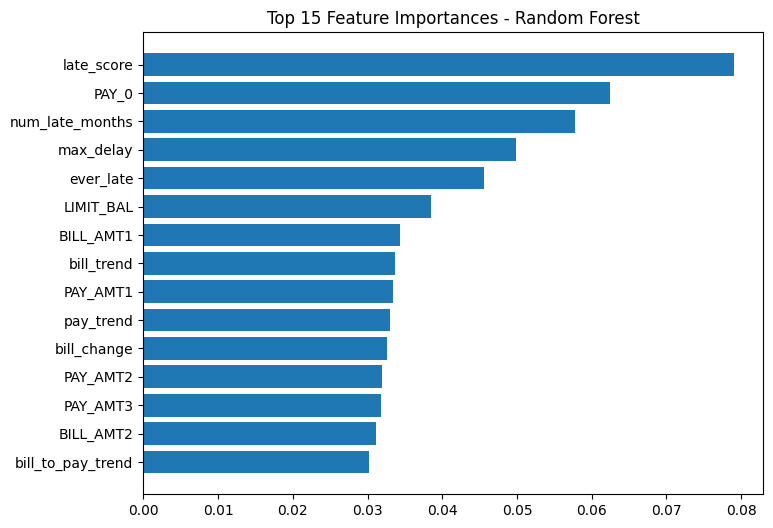

In [48]:
plt.figure(figsize=(8,6))
plt.barh(importances["feature"].head(15), importances["importance"].head(15))
plt.title("Top 15 Feature Importances - Random Forest")
plt.gca().invert_yaxis()
plt.show()

Random Forest identifies late_score, PAY_0, max_delay, and num_late_months as 
the most influential predictors, aligning with the expected relationship between 
timely repayment history and default risk. Engineered features such as late_score 
and bill/pay trends rank highly, demonstrating that non-linear models extract 
value from composite behavioral patterns that logistic regression treated with 
less stability. This supports the use of tree-based models for capturing 
interaction-driven credit risk signals.

## XGB Classifier

In [52]:
# we can use same x, y and preprocessor made for RF.
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()      # to handle class imbalance

pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        objective = "binary:logistic",
        eval_metric = "auc",
        scale_pos_weight = scale_pos_weight, 
        random_state = 42, 
        n_estimators = 300, 
        learning_rate = 0.05, 
        max_depth = 5
        ))
])

params_dist = {
    "model__n_estimators": np.linspace(300, 1200, 10, dtype=int), 
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
    "model__max_depth": [3, 5, 7, 9], 
    "model__min_child_weight": [1, 3, 5, 7, 10],  
    "model__subsample": [0.5, 0.7, 1.0] 
}

# Random search for best parameters
random_search = RandomizedSearchCV(pipeline, param_distributions=params_dist, n_iter=25, scoring="roc_auc", cv=3, n_jobs=-1, random_state=42, verbose=1)
random_search.fit(X_train, y_train)

print("Best from random search:", random_search.best_params_)
best = random_search.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best from random search: {'model__subsample': 0.5, 'model__n_estimators': 1000, 'model__min_child_weight': 1, 'model__max_depth': 3, 'model__learning_rate': 0.01}


Given the stability of the optimal hyperparameter configuration identified via RandomizedSearch, the model was evaluated without further refinement.


In [53]:
best_model_xgb = random_search.best_estimator_
# Evaluate model performance 
auc = cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring="roc_auc").mean()
f1 = cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring="f1").mean()

print("XGB Classifier - ROC AUC:", auc)
print("XGB Classifier - F1 Score:", f1)

XGB Classifier - ROC AUC: 0.7861253714118889
XGB Classifier - F1 Score: 0.5427014089042264


Logistic Regression, Random Forest, and XGBoost were evaluated to assess the trade-off between predictive performance and model complexity. While both Random Forest and XGBoost achieved slightly higher ROC-AUC and F1 scores than Logistic Regression, the improvements were marginal (approximately 0.01–0.02).
Ensemble stacking was considered; however, given the strong agreement among models and marginal performance differences, additional ensembling was not pursued.

Given the regulated nature of credit risk modeling and the importance of model transparency, these modest performance gains do not sufficiently justify the increased complexity and reduced interpretability of tree-based models. Logistic Regression already captures the dominant repayment risk signals while remaining easy to explain, audit, and deploy.

Random Forest and XGBoost therefore serve as validation models, confirming that no significant non-linear structure was left unmodeled, rather than as replacements for the final model.

Based on this trade-off, Logistic Regression is selected as the final model for this project.


### Threshold Selection

In [59]:
y_proba = best_model.predict_proba(X_test)[:, 1]

thresholds = [0.3, 0.4, 0.5]

results = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    results.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    })

threshold_results = pd.DataFrame(results)
threshold_results


,threshold,precision,recall,f1
0,0.3,0.270896,0.881688,0.414453
1,0.4,0.404977,0.674454,0.506079
2,0.5,0.452517,0.596081,0.514472


The logistic regression model outputs probabilities rather than binary decisions. To select an appropriate operating threshold, precision, recall, and F1 score were evaluated at multiple probability cutoffs.

A lower threshold (0.3) captures most defaulters but results in a high number of false positives, while a higher threshold (0.5) is more conservative but misses a larger portion of risky customers. A threshold of 0.4 provides a balanced trade-off, maintaining reasonable precision while substantially improving
recall relative to the default threshold.

Based on this trade-off, a probability threshold of **0.4** was selected for final evaluation.

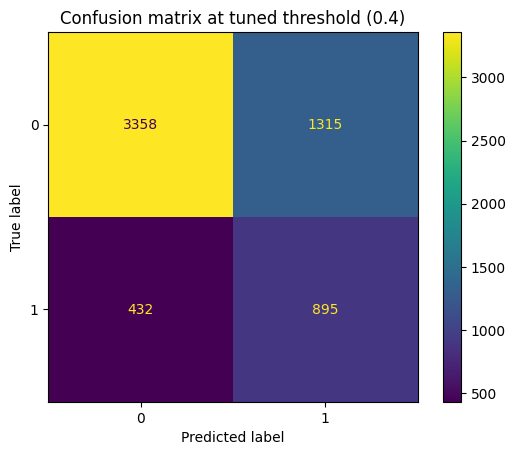

In [65]:
final_threshold = 0.4
y_final_pred = (y_proba >= final_threshold).astype(int)

cnf_final = confusion_matrix(y_test, y_final_pred)
ConfusionMatrixDisplay(cnf_final).plot()
plt.title("Confusion matrix at tuned threshold (0.4)")
plt.show()

In [61]:
print(classification_report(y_test, y_final_pred))

              precision    recall  f1-score   support

           0       0.89      0.72      0.79      4673
           1       0.40      0.67      0.51      1327

    accuracy                           0.71      6000
   macro avg       0.65      0.70      0.65      6000
weighted avg       0.78      0.71      0.73      6000



## Conclusion

This project explored credit card default prediction using extensive
exploratory analysis and feature engineering focused on repayment behavior,
credit utilization, and temporal patterns. Logistic Regression served as a
strong and interpretable baseline, while Random Forest and XGBoost were used
to assess the presence of non-linear structure.

Although tree-based models achieved marginally higher performance, the gains
were limited and did not justify the increased complexity and reduced
interpretability in a credit-risk context. Logistic Regression was therefore
selected as the final model.

A probability threshold of 0.4 was chosen to balance the trade-off between
identifying high-risk customers and limiting false positives. At this
operating point, the model captures a majority of defaulters while maintaining
reasonable precision, making it suitable as a risk screening tool.

Future improvements in a production setting would focus on cost-sensitive
threshold selection, fairness evaluation, and model monitoring rather than
additional model complexity.
